# 03_model_training.ipynb
## Causal Transformer Training

This notebook trains the Causal Transformer model on sessionized data.

### Workflow:
1. Load processed training and validation data
2. Initialize the Causal Transformer model
3. Set up training loop with early stopping
4. Train model and track metrics
5. Save best model checkpoint

In [1]:
# --- IMPORTS ---
import sys
import os
sys.path.append('..')  # Add parent directory to path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
from pathlib import Path
import json
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

from src.model import CausalTransformer
from src.dataloader import create_data_loader, load_vocabularies

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

In [2]:
# --- CONFIGURATION ---

# Model hyperparameters
MODEL_CONFIG = {
    'd_model': 128,
    'nhead': 4,
    'num_layers': 2,
    'dim_feedforward': 512,
    'dropout': 0.1,
    'max_seq_length': 500
}

# Training hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
EARLY_STOPPING_PATIENCE = 5
GRADIENT_CLIP_VAL = 1.0

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cpu


In [3]:
# --- LOAD DATA ---

# Find data files - use FIXED filenames (no timestamps)
data_dir = Path('./data')
models_dir = Path('./models')

# Use fixed filenames
train_path = data_dir / 'train_sessions.pkl'
val_path = data_dir / 'validation_sessions.pkl'
test_path = data_dir / 'test_sessions.pkl'

# Check if files exist
if not train_path.exists() or not val_path.exists():
    # Fallback to parquet if pickle doesn't exist
    train_path_pq = data_dir / 'train_sessions.parquet'
    val_path_pq = data_dir / 'validation_sessions.parquet'
    test_path_pq = data_dir / 'test_sessions.parquet'
    
    if train_path_pq.exists() and val_path_pq.exists():
        train_path = train_path_pq
        val_path = val_path_pq
        test_path = test_path_pq if test_path_pq.exists() else None
        file_format = 'parquet'
    else:
        raise FileNotFoundError("No session data found. Please run 02_data_processing.ipynb first.")
else:
    file_format = 'pickle'
    
print(f"Using {file_format} format:")
print(f"Training data: {train_path.name}")
print(f"Validation data: {val_path.name}")
if test_path and test_path.exists():
    print(f"Test data: {test_path.name}")

# Load vocabulary
vocab_path = models_dir / 'vocab.json'
if not vocab_path.exists():
    raise FileNotFoundError("Vocabulary file not found. Please run 02_data_processing.ipynb first.")

vocab = load_vocabularies(vocab_path)
print(f"\nVocabulary loaded:")
print(f"  Event types: {len(vocab['event_to_int'])}")
print(f"  Items: {len(vocab['item_to_int'])}")

# Validate vocabulary size matches expectation
expected_item_vocab_size = len(vocab['item_to_int'])
print(f"\nVocabulary validation:")
print(f"  Expected item vocabulary size: {expected_item_vocab_size}")
print(f"  Item ID range: [0, {expected_item_vocab_size-1}]")

Using pickle format:
Training data: train_sessions.pkl
Validation data: validation_sessions.pkl
Test data: test_sessions.pkl

Vocabulary loaded:
  Event types: 4
  Items: 2955

Vocabulary validation:
  Expected item vocabulary size: 2955
  Item ID range: [0, 2954]


In [4]:
# --- CREATE DATA LOADERS ---

print("\nCreating data loaders...")

# Debug: Confirm file paths
print(f"Loading from:")
print(f"  Train: {train_path}")
print(f"  Val: {val_path}")
print(f"  Format: {file_format}")

train_loader = create_data_loader(
    data_path=str(train_path),
    vocab_path=str(vocab_path),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0  # Set to 0 for debugging, increase for performance
)

val_loader = create_data_loader(
    data_path=str(val_path),
    vocab_path=str(vocab_path),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"\nData loaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")


Creating data loaders...
Loading from:
  Train: data/train_sessions.pkl
  Val: data/validation_sessions.pkl
  Format: pickle
Loaded 15 sessions from train_sessions.pkl
Loaded 3 sessions from validation_sessions.pkl

Data loaders created:
  Train batches: 1
  Validation batches: 1


In [5]:
# --- DATA VALIDATION ---

print("\nValidating data integrity...")

def validate_data_loader(loader, vocab, loader_name="DataLoader"):
    """Validate that all item IDs in the data are within vocabulary bounds."""
    max_item_id = len(vocab['item_to_int']) - 1
    max_event_id = len(vocab['event_to_int']) - 1
    
    print(f"\nValidating {loader_name}:")
    print(f"  Max allowed item ID: {max_item_id}")
    print(f"  Max allowed event ID: {max_event_id}")
    
    issues_found = False
    for batch_idx, batch in enumerate(loader):
        # Check item IDs
        item_ids = batch['item_ids']
        batch_max_item = item_ids.max().item()
        batch_min_item = item_ids.min().item()
        
        if batch_max_item > max_item_id:
            print(f"  ⚠️ Batch {batch_idx}: Item ID {batch_max_item} exceeds vocabulary size!")
            issues_found = True
        
        if batch_min_item < 0:
            print(f"  ⚠️ Batch {batch_idx}: Negative item ID {batch_min_item} found!")
            issues_found = True
            
        # Check event types
        event_types = batch['event_types']
        batch_max_event = event_types.max().item()
        batch_min_event = event_types.min().item()
        
        if batch_max_event > max_event_id:
            print(f"  ⚠️ Batch {batch_idx}: Event type {batch_max_event} exceeds vocabulary size!")
            issues_found = True
            
        if batch_min_event < 0:
            print(f"  ⚠️ Batch {batch_idx}: Negative event type {batch_min_event} found!")
            issues_found = True
    
    if not issues_found:
        print(f"  ✓ All IDs within valid range")
        print(f"  ✓ Item IDs: [{batch_min_item}, {batch_max_item}]")
        print(f"  ✓ Event types: [{batch_min_event}, {batch_max_event}]")
    else:
        raise ValueError(f"Data validation failed for {loader_name}! Please re-run 02_data_processing.ipynb")
    
    return not issues_found

# Validate both loaders
train_valid = validate_data_loader(train_loader, vocab, "Training DataLoader")
val_valid = validate_data_loader(val_loader, vocab, "Validation DataLoader")

if train_valid and val_valid:
    print("\n✅ All data validation checks passed!")


Validating data integrity...

Validating Training DataLoader:
  Max allowed item ID: 2954
  Max allowed event ID: 3
  ✓ All IDs within valid range
  ✓ Item IDs: [0, 2906]
  ✓ Event types: [0, 3]

Validating Validation DataLoader:
  Max allowed item ID: 2954
  Max allowed event ID: 3
  ✓ All IDs within valid range
  ✓ Item IDs: [0, 2952]
  ✓ Event types: [0, 3]

✅ All data validation checks passed!


In [6]:
# --- INITIALIZE MODEL ---

print("\nInitializing model...")

model = CausalTransformer(
    item_vocab_size=len(vocab['item_to_int']),
    event_vocab_size=len(vocab['event_to_int']),
    **MODEL_CONFIG
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel architecture:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"\nModel configuration:")
for key, value in MODEL_CONFIG.items():
    print(f"  {key}: {value}")


Initializing model...

Model architecture:
  Total parameters: 792,578
  Trainable parameters: 792,578

Model configuration:
  d_model: 128
  nhead: 4
  num_layers: 2
  dim_feedforward: 512
  dropout: 0.1
  max_seq_length: 500


In [7]:
# --- SETUP TRAINING ---

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=0.01
)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=3,
    factor=0.5,
    verbose=True
)

print("Training setup:")
print(f"  Loss function: BCEWithLogitsLoss")
print(f"  Optimizer: AdamW")
print(f"  Initial learning rate: {LEARNING_RATE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {NUM_EPOCHS}")
print(f"  Early stopping patience: {EARLY_STOPPING_PATIENCE}")

Training setup:
  Loss function: BCEWithLogitsLoss
  Optimizer: AdamW
  Initial learning rate: 0.0001
  Batch size: 128
  Max epochs: 50
  Early stopping patience: 5


In [8]:
# --- TRAINING FUNCTIONS ---

def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(loader, desc='Training')
    for batch in progress_bar:
        # Move batch to device
        event_types = batch['event_types'].to(device)
        item_ids = batch['item_ids'].to(device)
        time_deltas = batch['time_deltas'].to(device)
        sequence_lengths = batch['sequence_lengths'].to(device)
        treatments = batch['treatments'].to(device)
        outcomes = batch['outcomes'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits, alpha, beta = model(
            event_types, item_ids, time_deltas, 
            sequence_lengths, treatments
        )
        
        # Compute loss
        loss = criterion(logits, outcomes.float())
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
        
        # Update weights
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item() * len(outcomes)
        predictions = (torch.sigmoid(logits) > 0.5).long()
        correct += (predictions == outcomes).sum().item()
        total += len(outcomes)
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': correct / total
        })
    
    return total_loss / total, correct / total


def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(loader, desc='Validation')
        for batch in progress_bar:
            # Move batch to device
            event_types = batch['event_types'].to(device)
            item_ids = batch['item_ids'].to(device)
            time_deltas = batch['time_deltas'].to(device)
            sequence_lengths = batch['sequence_lengths'].to(device)
            treatments = batch['treatments'].to(device)
            outcomes = batch['outcomes'].to(device)
            
            # Forward pass
            logits, alpha, beta = model(
                event_types, item_ids, time_deltas,
                sequence_lengths, treatments
            )
            
            # Compute loss
            loss = criterion(logits, outcomes.float())
            
            # Track metrics
            total_loss += loss.item() * len(outcomes)
            predictions = (torch.sigmoid(logits) > 0.5).long()
            correct += (predictions == outcomes).sum().item()
            total += len(outcomes)
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': loss.item(),
                'acc': correct / total
            })
    
    return total_loss / total, correct / total

In [9]:
# --- TRAINING LOOP ---

print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rate': []
}

# Early stopping variables
best_val_loss = float('inf')
patience_counter = 0
best_model_path = models_dir / 'best_model.pt'

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 40)
    
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Validate
    val_loss, val_acc = validate_epoch(
        model, val_loader, criterion, device
    )
    
    # Update scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rate'].append(current_lr)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"  Learning Rate: {current_lr:.6f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'model_config': MODEL_CONFIG,
            'vocab_size': {
                'items': len(vocab['item_to_int']),
                'events': len(vocab['event_to_int'])
            }
        }, best_model_path)
        
        print(f"  ✓ New best model saved (val_loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  No improvement. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")
        
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print("\n" + "="*40)
            print("Early stopping triggered!")
            print("="*40)
            break

print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)
print(f"\nBest validation loss: {best_val_loss:.4f}")
print(f"Model saved to: {best_model_path}")


STARTING TRAINING

Epoch 1/50
----------------------------------------


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Validation: 100%|██████████| 1/1 [00:00<00:00, 83.30it/s, loss=1.75, acc=0.333]



Epoch 1 Summary:
  Train Loss: 0.5580, Train Acc: 0.8000
  Val Loss: 1.7480, Val Acc: 0.3333
  Learning Rate: 0.000100
  ✓ New best model saved (val_loss: 1.7480)

Epoch 2/50
----------------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00, 262.31it/s, loss=1.45, acc=0.333]



Epoch 2 Summary:
  Train Loss: 0.4697, Train Acc: 0.8000
  Val Loss: 1.4513, Val Acc: 0.3333
  Learning Rate: 0.000100
  ✓ New best model saved (val_loss: 1.4513)

Epoch 3/50
----------------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00, 226.03it/s, loss=1.28, acc=0.333]



Epoch 3 Summary:
  Train Loss: 0.5796, Train Acc: 0.8000
  Val Loss: 1.2772, Val Acc: 0.3333
  Learning Rate: 0.000100
  ✓ New best model saved (val_loss: 1.2772)

Epoch 4/50
----------------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00, 196.78it/s, loss=1.12, acc=0.333]



Epoch 4 Summary:
  Train Loss: 0.5009, Train Acc: 0.7333
  Val Loss: 1.1210, Val Acc: 0.3333
  Learning Rate: 0.000100
  ✓ New best model saved (val_loss: 1.1210)

Epoch 5/50
----------------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00, 208.20it/s, loss=1.06, acc=0.333]



Epoch 5 Summary:
  Train Loss: 0.5321, Train Acc: 0.8000
  Val Loss: 1.0607, Val Acc: 0.3333
  Learning Rate: 0.000100
  ✓ New best model saved (val_loss: 1.0607)

Epoch 6/50
----------------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00, 198.61it/s, loss=1.06, acc=0.333]



Epoch 6 Summary:
  Train Loss: 0.4805, Train Acc: 0.7333
  Val Loss: 1.0613, Val Acc: 0.3333
  Learning Rate: 0.000100
  No improvement. Patience: 1/5

Epoch 7/50
----------------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00, 236.23it/s, loss=1.1, acc=0.333]



Epoch 7 Summary:
  Train Loss: 0.5336, Train Acc: 0.7333
  Val Loss: 1.1032, Val Acc: 0.3333
  Learning Rate: 0.000100
  No improvement. Patience: 2/5

Epoch 8/50
----------------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00, 249.08it/s, loss=1.19, acc=0.333]



Epoch 8 Summary:
  Train Loss: 0.5433, Train Acc: 0.7333
  Val Loss: 1.1851, Val Acc: 0.3333
  Learning Rate: 0.000100
  No improvement. Patience: 3/5

Epoch 9/50
----------------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00, 62.49it/s, loss=1.3, acc=0.333]



Epoch 9 Summary:
  Train Loss: 0.4784, Train Acc: 0.7333
  Val Loss: 1.2987, Val Acc: 0.3333
  Learning Rate: 0.000050
  No improvement. Patience: 4/5

Epoch 10/50
----------------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00, 251.83it/s, loss=1.36, acc=0.333]


Epoch 10 Summary:
  Train Loss: 0.5605, Train Acc: 0.8000
  Val Loss: 1.3579, Val Acc: 0.3333
  Learning Rate: 0.000050
  No improvement. Patience: 5/5

Early stopping triggered!

TRAINING COMPLETE

Best validation loss: 1.0607
Model saved to: models/best_model.pt


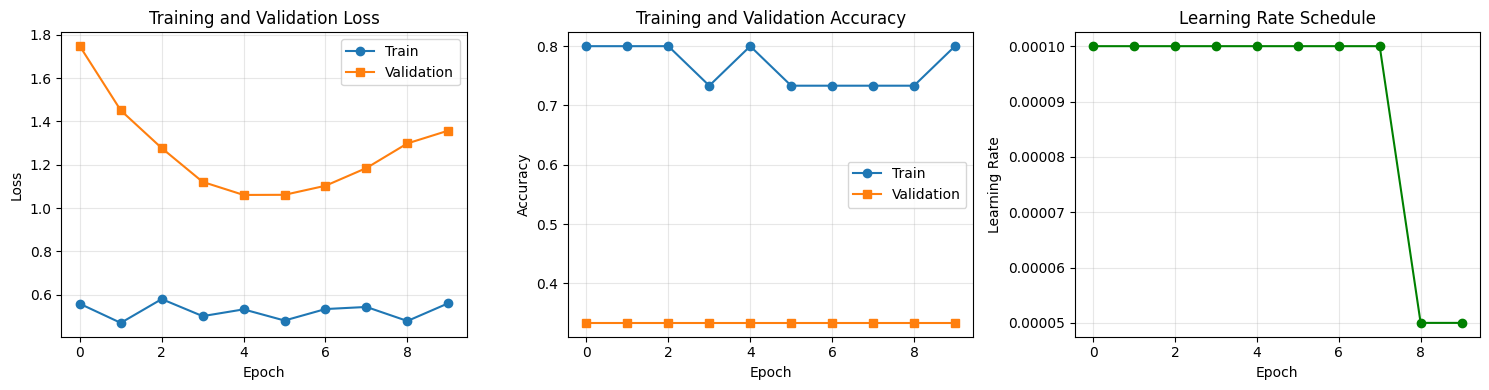


Training history saved to: models/training_history_20250926_113011.csv


In [10]:
# --- PLOT TRAINING HISTORY ---

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss plot
axes[0].plot(history['train_loss'], label='Train', marker='o')
axes[0].plot(history['val_loss'], label='Validation', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train', marker='o')
axes[1].plot(history['val_acc'], label='Validation', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning rate plot
axes[2].plot(history['learning_rate'], marker='o', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save training history
history_df = pd.DataFrame(history)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
history_path = models_dir / f'training_history_{timestamp}.csv'
history_df.to_csv(history_path, index=False)
print(f"\nTraining history saved to: {history_path}")

## Model Inspection

In [11]:
# --- ANALYZE LEARNED CAUSAL EFFECTS ---

print("\nAnalyzing learned causal effects on validation set...")

# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Collect alpha and beta values
all_alphas = []
all_betas = []
all_treatments = []
all_outcomes = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc='Extracting causal effects'):
        # Move batch to device
        event_types = batch['event_types'].to(device)
        item_ids = batch['item_ids'].to(device)
        time_deltas = batch['time_deltas'].to(device)
        sequence_lengths = batch['sequence_lengths'].to(device)
        treatments = batch['treatments'].to(device)
        outcomes = batch['outcomes'].to(device)
        
        # Get model outputs
        _, alpha, beta = model(
            event_types, item_ids, time_deltas,
            sequence_lengths, treatments
        )
        
        # Convert to probabilities
        alpha_prob = torch.sigmoid(alpha)
        treated_prob = torch.sigmoid(alpha + beta)
        beta_lift = treated_prob - alpha_prob
        
        # Collect values
        all_alphas.extend(alpha_prob.cpu().numpy())
        all_betas.extend(beta_lift.cpu().numpy())
        all_treatments.extend(treatments.cpu().numpy())
        all_outcomes.extend(outcomes.cpu().numpy())

# Convert to numpy arrays
all_alphas = np.array(all_alphas)
all_betas = np.array(all_betas)
all_treatments = np.array(all_treatments)
all_outcomes = np.array(all_outcomes)

print("\nCausal Effect Statistics:")
print(f"  Average α (baseline propensity): {all_alphas.mean():.4f} ± {all_alphas.std():.4f}")
print(f"  Average β (treatment effect): {all_betas.mean():.4f} ± {all_betas.std():.4f}")
print(f"  Min β: {all_betas.min():.4f}")
print(f"  Max β: {all_betas.max():.4f}")
print(f"  Sessions with positive effect: {(all_betas > 0).mean():.1%}")


Analyzing learned causal effects on validation set...


Extracting causal effects: 100%|██████████| 1/1 [00:00<00:00, 233.06it/s]


Causal Effect Statistics:
  Average α (baseline propensity): 0.6320 ± 0.1123
  Average β (treatment effect): 0.1277 ± 0.0195
  Min β: 0.1125
  Max β: 0.1553
  Sessions with positive effect: 100.0%


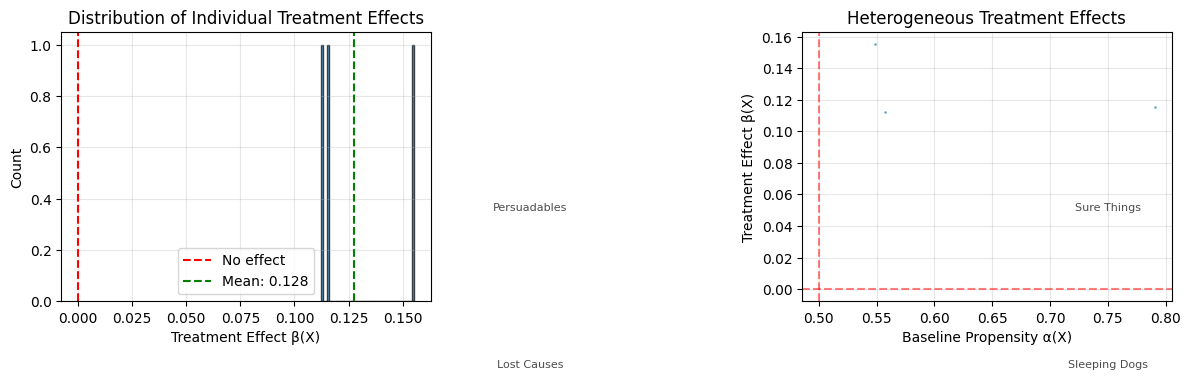


Quadrant Analysis:
0.63199776
  Sure Things: 33.3%
  Persuadables: 66.7%
  Lost Causes: 0.0%
  Sleeping Dogs: 0.0%


In [12]:
# --- VISUALIZE HETEROGENEITY ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution of treatment effects
axes[0].hist(all_betas, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', label='No effect')
axes[0].axvline(x=all_betas.mean(), color='green', linestyle='--', label=f'Mean: {all_betas.mean():.3f}')
axes[0].set_xlabel('Treatment Effect β(X)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Individual Treatment Effects')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot: baseline vs treatment effect
axes[1].scatter(all_alphas, all_betas, alpha=0.5, s=1)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Baseline Propensity α(X)')
axes[1].set_ylabel('Treatment Effect β(X)')
axes[1].set_title('Heterogeneous Treatment Effects')
axes[1].grid(True, alpha=0.3)

# Add quadrant labels
axes[1].text(0.75, 0.05, 'Sure Things', ha='center', fontsize=8, alpha=0.7)
axes[1].text(0.25, 0.05, 'Persuadables', ha='center', fontsize=8, alpha=0.7)
axes[1].text(0.25, -0.05, 'Lost Causes', ha='center', fontsize=8, alpha=0.7)
axes[1].text(0.75, -0.05, 'Sleeping Dogs', ha='center', fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

print("\nQuadrant Analysis:")
cutoff = all_alphas.mean()
print(cutoff)
sure_things = ((all_alphas > cutoff) & (all_betas > 0)).mean()
persuadables = ((all_alphas <= cutoff) & (all_betas > 0)).mean()
lost_causes = ((all_alphas <= cutoff) & (all_betas <= 0)).mean()
sleeping_dogs = ((all_alphas > cutoff) & (all_betas <= 0)).mean()

print(f"  Sure Things: {sure_things:.1%}")
print(f"  Persuadables: {persuadables:.1%}")
print(f"  Lost Causes: {lost_causes:.1%}")
print(f"  Sleeping Dogs: {sleeping_dogs:.1%}")

In [13]:
# --- SAVE FINAL OUTPUTS ---

# Save model summary to text file
summary_path = models_dir / f'model_summary_{timestamp}.txt'
with open(summary_path, 'w') as f:
    f.write("CAUSAL TRANSFORMER TRAINING SUMMARY\n")
    f.write("="*80 + "\n\n")
    
    f.write("Model Configuration:\n")
    for key, value in MODEL_CONFIG.items():
        f.write(f"  {key}: {value}\n")
    
    f.write(f"\nVocabulary Size:\n")
    f.write(f"  Events: {len(vocab['event_to_int'])}\n")
    f.write(f"  Items: {len(vocab['item_to_int'])}\n")
    
    f.write(f"\nModel Parameters:\n")
    f.write(f"  Total: {total_params:,}\n")
    f.write(f"  Trainable: {trainable_params:,}\n")
    
    f.write(f"\nTraining Configuration:\n")
    f.write(f"  Batch size: {BATCH_SIZE}\n")
    f.write(f"  Initial learning rate: {LEARNING_RATE}\n")
    f.write(f"  Epochs trained: {len(history['train_loss'])}\n")
    
    f.write(f"\nFinal Performance:\n")
    f.write(f"  Best validation loss: {best_val_loss:.4f}\n")
    f.write(f"  Final validation accuracy: {history['val_acc'][-1]:.4f}\n")
    
    f.write(f"\nCausal Effect Statistics:\n")
    f.write(f"  Average α (baseline): {all_alphas.mean():.4f} ± {all_alphas.std():.4f}\n")
    f.write(f"  Average β (effect): {all_betas.mean():.4f} ± {all_betas.std():.4f}\n")
    f.write(f"  Sessions with positive effect: {(all_betas > 0).mean():.1%}\n")
    
    f.write(f"\nQuadrant Distribution:\n")
    f.write(f"  Sure Things: {sure_things:.1%}\n")
    f.write(f"  Persuadables: {persuadables:.1%}\n")
    f.write(f"  Lost Causes: {lost_causes:.1%}\n")
    f.write(f"  Sleeping Dogs: {sleeping_dogs:.1%}\n")

print(f"\nTraining summary saved to: {summary_path}")
print("\nAll artifacts saved. Ready for causal analysis!")


Training summary saved to: models/model_summary_20250926_113011.txt

All artifacts saved. Ready for causal analysis!
